In [1]:
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import os
from skimage.feature import hog
from scipy.spatial import distance

In [2]:
def siftCompare(target, test, filter = True, show_img = True, contrastThreshold = 0.04, edgeThreshold = 10):

    # Testing if it will work better with gaussian filters
    if(filter):
        target = cv.GaussianBlur(target, (5,5), 0)
        test = cv.GaussianBlur(test, (5,5), 0)

    sift = cv.SIFT_create(edgeThreshold=edgeThreshold, contrastThreshold=contrastThreshold)

    kp1, des1 = sift.detectAndCompute(target, None)
    kp2, des2 = sift.detectAndCompute(test, None)

    bf = cv.BFMatcher()
    matches = bf.knnMatch(des1, des2, k=2)

    good_matches = []
    for m, n in matches:
        if m.distance < 0.75 * n.distance:
            good_matches.append(m)

    # unique_matches = []
    # unique_query_index = set()

    # for match in good_matches:
    #     query_idx = match.queryIdx
    #     train_idx = match.trainIdx
    #     if train_idx not in unique_query_index:
    #         unique_matches.append(match)
    #         unique_query_index.add(query_idx)

    match_image = cv.drawMatches(target, kp1, test, kp2, good_matches, None, flags=2)

    score = len(good_matches) / min(len(kp1), len(kp2)) * 100

    if(show_img):
        print(score)
        plt.imshow(match_image, cmap = 'gray')
        plt.show()

    return score, match_image

In [3]:
def histCompare(image1, image2):

    hsv1 = cv.cvtColor(image1, cv.COLOR_BGR2HSV)
    hsv2 = cv.cvtColor(image2, cv.COLOR_BGR2HSV)
    hist1_h = cv.calcHist([hsv1], [0], None, [180], [0, 180])
    hist1_s = cv.calcHist([hsv1], [1], None, [256], [0, 256])
    hist1_v = cv.calcHist([hsv1], [2], None, [256], [0, 256])
    hist2_h = cv.calcHist([hsv2], [0], None, [180], [0, 180])
    hist2_s = cv.calcHist([hsv2], [1], None, [256], [0, 256])
    hist2_v = cv.calcHist([hsv2], [2], None, [256], [0, 256])

    hist1_h = cv.normalize(hist1_h, hist1_h, 0, 1, cv.NORM_MINMAX)
    hist1_s = cv.normalize(hist1_s, hist1_s, 0, 1, cv.NORM_MINMAX)
    hist1_v = cv.normalize(hist1_v, hist1_v, 0, 1, cv.NORM_MINMAX)
    hist2_h = cv.normalize(hist2_h, hist2_h, 0, 1, cv.NORM_MINMAX)
    hist2_s = cv.normalize(hist2_s, hist2_s, 0, 1, cv.NORM_MINMAX)
    hist2_v = cv.normalize(hist2_v, hist2_v, 0, 1, cv.NORM_MINMAX)

    bd_h = cv.compareHist(hist1_h, hist2_h, cv.HISTCMP_BHATTACHARYYA)
    bd_s = cv.compareHist(hist1_s, hist2_s, cv.HISTCMP_BHATTACHARYYA)
    bd_v = cv.compareHist(hist1_v, hist2_v, cv.HISTCMP_BHATTACHARYYA)

    weight_h = 1.0 
    weight_s = 1.0
    weight_v = 1.0

    overall_similarity = (weight_h * (1 - bd_h) + weight_s * (1 - bd_s) + weight_v * (1 - bd_v)) / (weight_h + weight_s + weight_v)

    return overall_similarity * 100


In [4]:
def hogCompare(image1, image2, size = 12):
    pixel_size = (size, size)
    fd1, hog_image1 = hog(image1, orientations=8, pixels_per_cell= pixel_size,
                        cells_per_block=(1, 1), visualize=True, channel_axis=-1)
    fd2, hog_image2 = hog(image2, orientations=8, pixels_per_cell= pixel_size,
                        cells_per_block=(1, 1), visualize=True, channel_axis=-1)
    score = distance.correlation(fd1, fd2)

    return score

02.jpg 08.jpg are the Same picture!


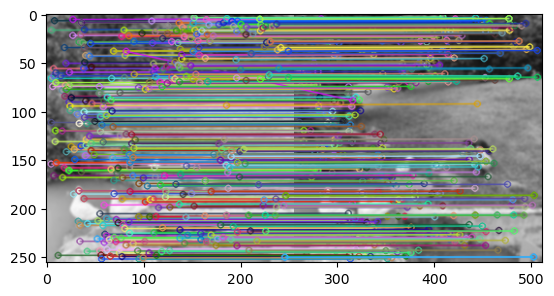

02.jpg 20.jpg are the Same picture!


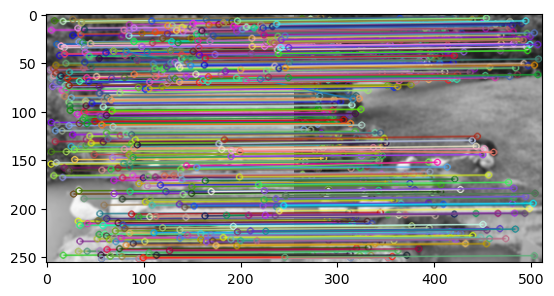

04.jpg 11.jpg are the Same picture!


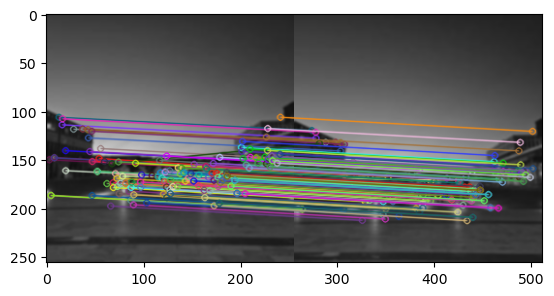

04.jpg 15.jpg are the Same picture!


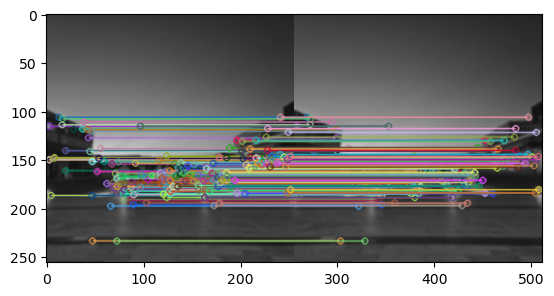

05.jpg and 09.jpg are similar!


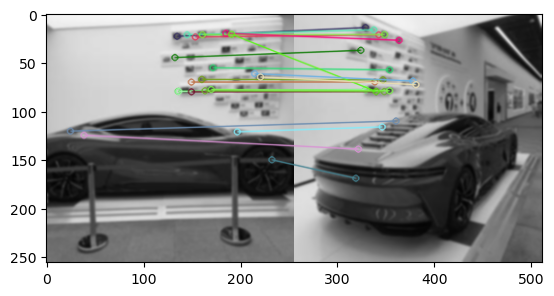

05.jpg and 12.jpg are similar!


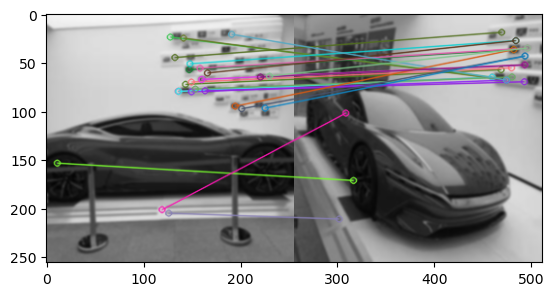

08.jpg 02.jpg are the Same picture!


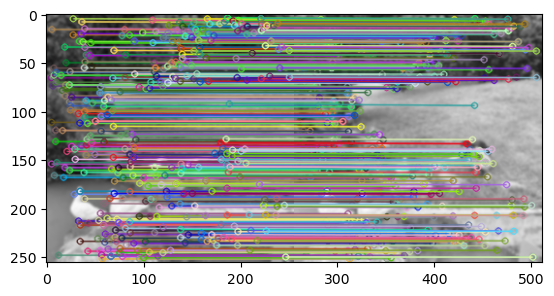

08.jpg 20.jpg are the Same picture!


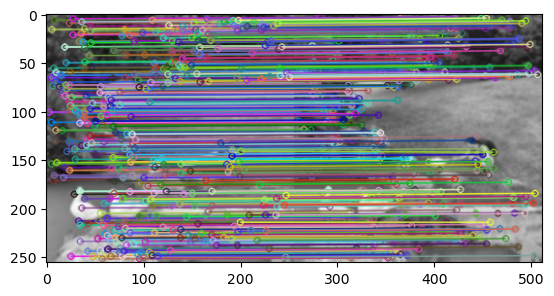

09.jpg and 05.jpg are similar!


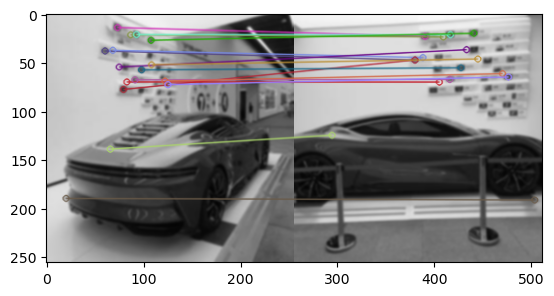

10.jpg and 13.jpg are similar!


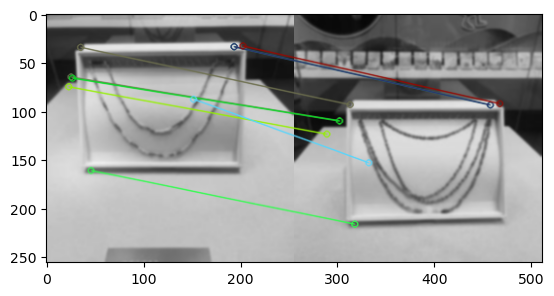

11.jpg 04.jpg are the Same picture!


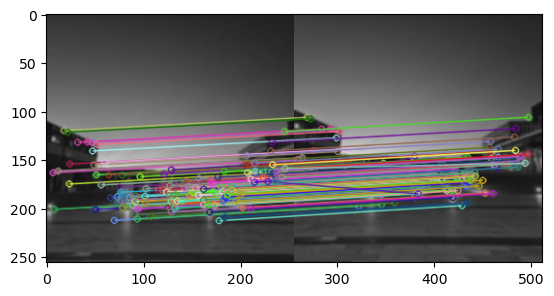

11.jpg 15.jpg are the Same picture!


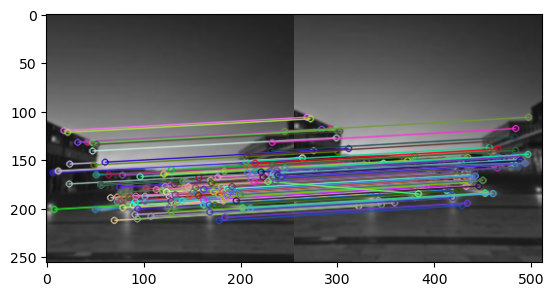

12.jpg and 05.jpg are similar!


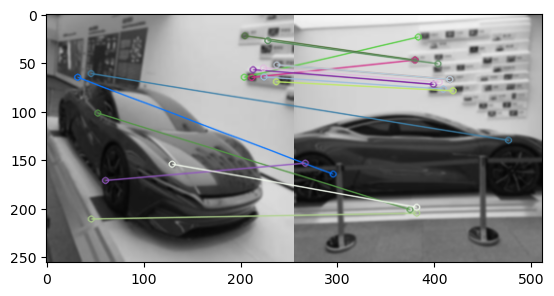

13.jpg and 10.jpg are similar!


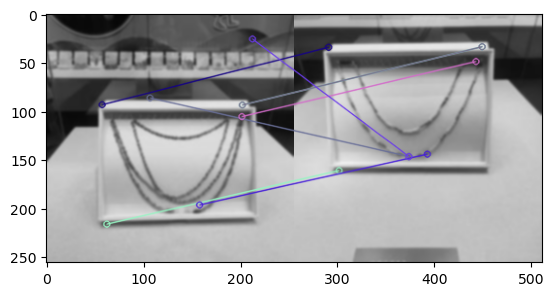

15.jpg 04.jpg are the Same picture!


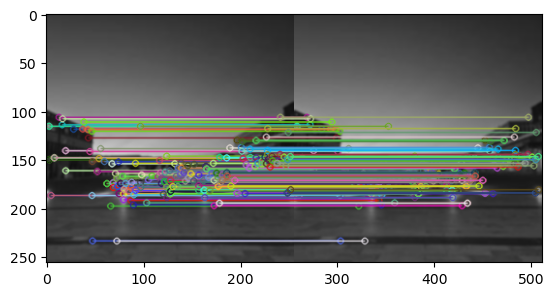

15.jpg 11.jpg are the Same picture!


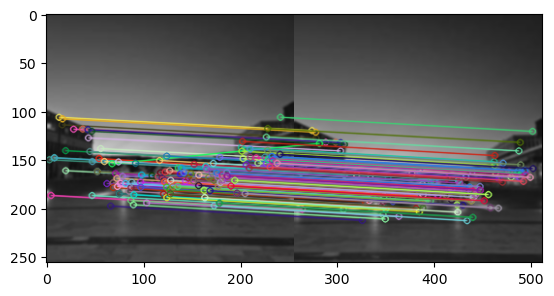

16.jpg and 19.jpg are similar!


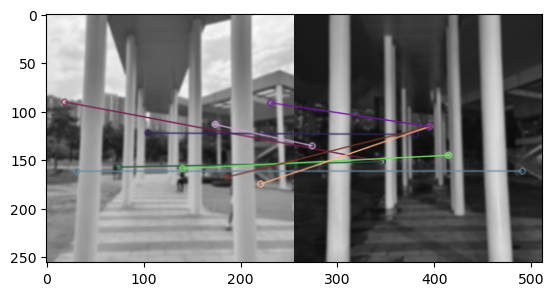

19.jpg and 16.jpg are similar!


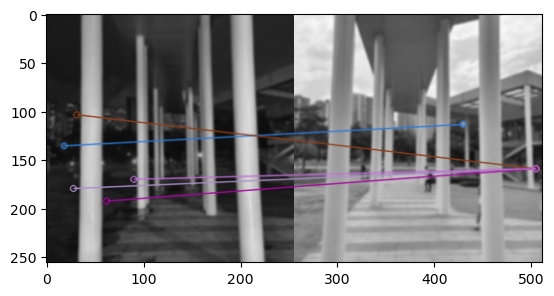

20.jpg 02.jpg are the Same picture!


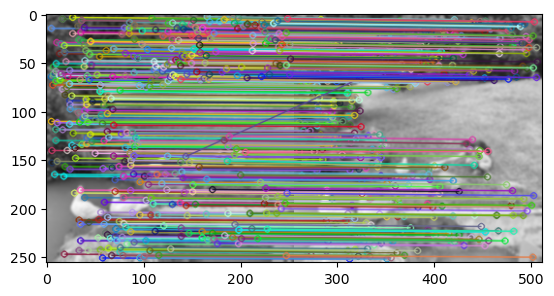

20.jpg 08.jpg are the Same picture!


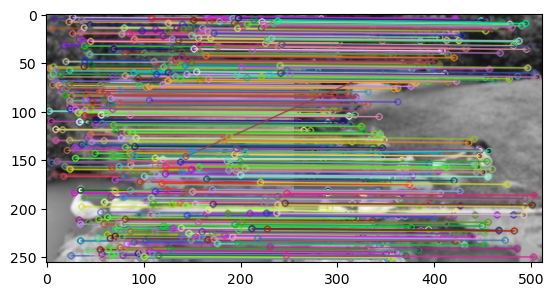

In [5]:
filenames = os.listdir("./dataset/img_256")
filenames.sort()

for file1 in filenames:
    target = cv.imread('./dataset/img_256/' + file1, cv.IMREAD_COLOR)
    target_gray = cv.cvtColor(target, cv.COLOR_BGR2GRAY)
    for file2 in filenames:
        if file1 == file2:
            continue

        test = cv.imread('./dataset/img_256/' + file2, cv.IMREAD_COLOR)
        test_gray = cv.cvtColor(test, cv.COLOR_BGR2GRAY)
        # print("=======")
        # print("Comaring with " + file1 + " with " + file2 + " ...")

        sift_score, out_img = siftCompare(target_gray, test_gray, show_img=False, contrastThreshold=0.04, edgeThreshold=10)
        # print("SIFT score: " + str(sift_score))

        hist_score = histCompare(target, test)
        # print("Histogram score: " + str(hist_score))

        hog_score = hogCompare(target, test)
        # print("HOG score: " + str(hog_score))

        if sift_score > 8 and hist_score > 60:
            if hist_score > 80:
                print(file1 + " " + file2 + " are the " + "Same picture!")
            else:
                print(file1 + " and " + file2 + " are similar!")

            plt.imshow(out_img, cmap = 'gray')
            plt.show()
        elif 0.3 < hog_score < 0.5:
            print(file1 + " and " + file2 + " are similar!")
            plt.imshow(out_img, cmap = 'gray')
            plt.show()

